<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/Classifiers_with_TF_IDF_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What is the difference between Word2Vec and TF-IDF vectorizer?
Word2Vec vs. BoW and TF-IDF: Word2Vec is a neural network-based technique that learns continuous word embeddings, capturing the semantic relationships between words

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import string

RANDOM_SEED = 42 # Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
dataset=pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

# Tokenization

In [ ]:
class_distribution = dataset['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):  # Fixed this line
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())


                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


## Save the cleaned dataset

In [ ]:
# Save the cleaned dataset as an Excel file
dataset.to_excel('cleaned_14932_ARPs_and_Programming_Posts.xlsx', index=False, engine='openpyxl')

## lemmatizer, Remove stopwords, etc.

In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(lemmatized)


# Ensure all values in 'Question_body' are strings and handle NaNs and # Convert 'Question_body' to string (to avoid NaN issues)
dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed_tf_idf'] = dataset['Question_body_cleaned'].apply(preprocess_text)


## Save processed dataset

In [ ]:
# Save processed dataset
dataset.to_excel('Preprocessed_14932_ARPs_and_Programming_Posts.xlsx', index=False)

dataset.head()

# Split dataset

In [ ]:
x = dataset['Question_body_preprocessed_tf_idf']
y = dataset['Label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=125)


# Features Engineering with TF-IDF

In [ ]:
# Initialize TF-IDF vectorizer
tf_idf_vector = TfidfVectorizer(min_df=2).fit(X_train)

# Transform training and test data
X_train_vect_tf_idf = tf_idf_vector.transform(X_train).toarray()
X_test_vect_tf_idf = tf_idf_vector.transform(X_test).toarray()


## Save the TF-IDF embeddings for the entire dataset

In [ ]:
# Save the TF-IDF embeddings for the entire dataset
embeddings = tf_idf_vector.transform(df['Question_body_preprocessed_tf_idf']).toarray()

# Create a new DataFrame for the embeddings
embeddings_df = pd.DataFrame(embeddings, columns=tf_idf_vector.get_feature_names_out())


# Save the embeddings to an Excel file
embeddings_df.to_excel('tfidf_embeddings.xlsx', index=False)

# Print confirmation
print("TF-IDF embeddings saved to 'tfidf_embeddings.xlsx'.")

# NB_TF-IDF

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
#nb_model = GaussianNB()
nb_model=GaussianNB(
    priors=None,      # No predefined class priors; computed from the data
    var_smoothing=1e-9 # Small value added to variances for numerical stability
)
nb_model = nb_model.fit(X_train_vect_tf_idf, y_train)


# Predict on the test set
y_pred = nb_model.predict(X_test_vect_tf_idf)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.7854034147974557
Class 0 - Precision: 0.7476580796252927, Recall: 0.8587760591795561, Accuracy: 0.7854034147974557, F1-score: 0.7993740219092331
Class 1 - Precision: 0.8358092259577795, Recall: 0.7126666666666667, Accuracy: 0.7854034147974557, F1-score: 0.7693414897445124


### Overall-NB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train Naive Bayes model
#nb_model = GaussianNB()
nb_model=GaussianNB(
    priors=None,      # No predefined class priors; computed from the data
    var_smoothing=1e-9 # Small value added to variances for numerical stability
)

nb_model = nb_model.fit(X_train_vect_tf_idf, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test_vect_tf_idf)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


Overall Precision: 0.8358092259577795
Overall Recall: 0.7126666666666667
Overall F1-score: 0.7693414897445124
Overall Accuracy: 0.7854034147974557


## Confusion_Matrix_NB

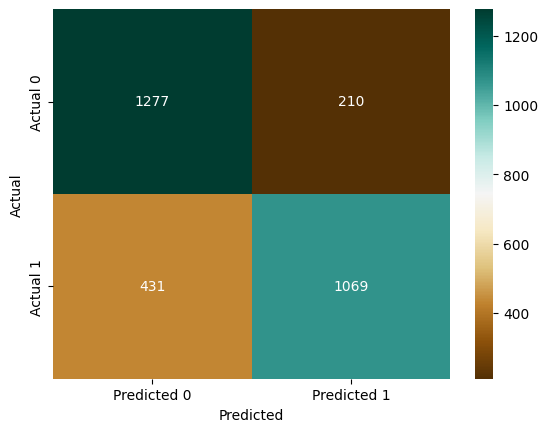

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='BrBG', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# kNN_TF-IDF

## Normal Performance Evaluation for kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model=KNeighborsClassifier(
    n_neighbors=1,      # Number of neighbors to consider (default is 5, but set to 1 in your case)
    weights='uniform',  # All neighbors have equal weight ('distance' would weigh closer neighbors more)
    algorithm='auto',   # Chooses the best algorithm based on data ('ball_tree', 'kd_tree', or 'brute' can be set manually)
    leaf_size=30,       # Affects 'ball_tree' and 'kd_tree' algorithms (ignored for 'brute')
    p=2,                # Power parameter for Minkowski distance (p=2 corresponds to Euclidean distance, p=1 is Manhattan)
    metric='minkowski', # Default distance metric (with p=2, this is Euclidean distance)
    metric_params=None, # No additional parameters for the metric
    n_jobs=None         # No parallel processing (set to -1 to use all CPU cores)
)

knn_model.fit(X_train_vect_tf_idf, y_train)


# Predict on the test set
y_pred = knn_model.predict(X_test_vect_tf_idf)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.5323066622028791
Class 0 - Precision: 0.5158116654954322, Recall: 0.9872225958305313, Accuracy: 0.5323066622028791, F1-score: 0.6775905838910685
Class 1 - Precision: 0.8652482269503546, Recall: 0.08133333333333333, Accuracy: 0.5323066622028791, F1-score: 0.14868982327848873


### Overal- kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

# Train KNN model
#knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model=KNeighborsClassifier(
    n_neighbors=1,      # Number of neighbors to consider (default is 5, but set to 1 in your case)
    weights='uniform',  # All neighbors have equal weight ('distance' would weigh closer neighbors more)
    algorithm='auto',   # Chooses the best algorithm based on data ('ball_tree', 'kd_tree', or 'brute' can be set manually)
    leaf_size=30,       # Affects 'ball_tree' and 'kd_tree' algorithms (ignored for 'brute')
    p=2,                # Power parameter for Minkowski distance (p=2 corresponds to Euclidean distance, p=1 is Manhattan)
    metric='minkowski', # Default distance metric (with p=2, this is Euclidean distance)
    metric_params=None, # No additional parameters for the metric
    n_jobs=None         # No parallel processing (set to -1 to use all CPU cores)
)
knn_model.fit(X_train_vect_tf_idf, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test_vect_tf_idf)

# Compute overall metrics (precision, recall, f1-score)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


Overall Precision: 0.8652482269503546
Overall Recall: 0.08133333333333333
Overall F1-score: 0.14868982327848873
Overall Accuracy: 0.5323066622028791


## Matrix_kNN

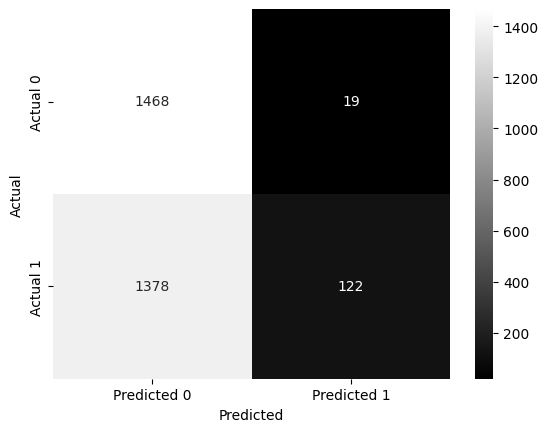

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='gray', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DT_TF-IDF

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
#dt_model = DecisionTreeClassifier()
dt_model=DecisionTreeClassifier(
    criterion='gini',          # Splitting criterion ('gini' for Gini impurity, or 'entropy' for information gain)
    splitter='best',           # Chooses the best split at each node ('random' selects a random split)
    max_depth=None,            # No depth limit (tree grows until all leaves are pure or min_samples_split is reached)
    min_samples_split=2,       # Minimum samples required to split an internal node
    min_samples_leaf=1,        # Minimum samples required to be a leaf node
    min_weight_fraction_leaf=0.0, # Minimum weighted fraction of total samples required in a leaf node
    max_features=None,         # No limit on the number of features considered for the best split
    random_state=None,         # No fixed randomness by default
    max_leaf_nodes=None,       # No limit on the number of leaf nodes
    min_impurity_decrease=0.0, # A node splits if it decreases impurity by at least this amount
    class_weight=None,         # No class weighting by default
    ccp_alpha=0.0              # Complexity parameter for pruning (0 means no pruning)
)

dt_model = dt_model.fit(X_train_vect_tf_idf, y_train)


# Predict on the test set
y_pred = dt_model.predict(X_test_vect_tf_idf)

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')

Overall Accuracy: 0.8727820555741547
Class 0 - Precision: 0.8658294778585591, Recall: 0.8809683927370545, Accuracy: 0.8727820555741547, F1-score: 0.8733333333333333
Class 1 - Precision: 0.8799185888738128, Recall: 0.8646666666666667, Accuracy: 0.8727820555741547, F1-score: 0.8722259583053127


### Overall- DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train Decision Tree model
#dt_model = DecisionTreeClassifier()
dt_model=DecisionTreeClassifier(
    criterion='gini',          # Splitting criterion ('gini' for Gini impurity, or 'entropy' for information gain)
    splitter='best',           # Chooses the best split at each node ('random' selects a random split)
    max_depth=None,            # No depth limit (tree grows until all leaves are pure or min_samples_split is reached)
    min_samples_split=2,       # Minimum samples required to split an internal node
    min_samples_leaf=1,        # Minimum samples required to be a leaf node
    min_weight_fraction_leaf=0.0, # Minimum weighted fraction of total samples required in a leaf node
    max_features=None,         # No limit on the number of features considered for the best split
    random_state=None,         # No fixed randomness by default
    max_leaf_nodes=None,       # No limit on the number of leaf nodes
    min_impurity_decrease=0.0, # A node splits if it decreases impurity by at least this amount
    class_weight=None,         # No class weighting by default
    ccp_alpha=0.0              # Complexity parameter for pruning (0 means no pruning)
)
dt_model = dt_model.fit(X_train_vect_tf_idf, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test_vect_tf_idf)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')

Overall Precision: 0.8910478834142956
Overall Recall: 0.856
Overall F1-score: 0.8731723903434206
Overall Accuracy: 0.8751255440241045


## Matrix_DT

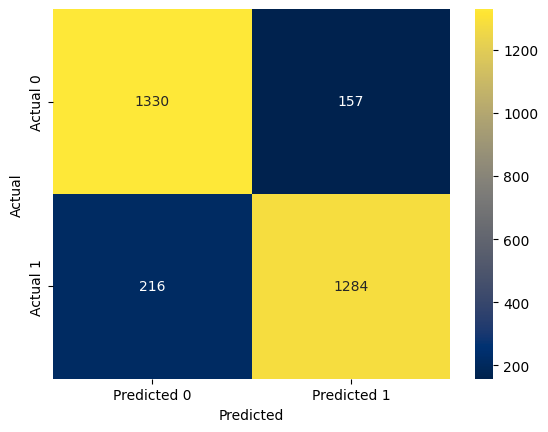

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# LG_TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
#lg_model = LogisticRegression(C=5, penalty='l1', solver='liblinear')
lg_model=LogisticRegression(
    penalty='l2',      # Default is L2 regularization (Ridge)
    dual=False,        # Dual formulation is only used when `penalty='l2'` and the number of samples > number of features
    tol=1e-4,          # Tolerance for stopping criteria
    C=1.0,             # Inverse of regularization strength (1.0 means moderate regularization)
    fit_intercept=True,# Whether to include an intercept term
    intercept_scaling=1, # Only relevant for `solver='liblinear'`
    class_weight=None, # No class weighting by default
    random_state=None, # No fixed randomness
    solver='lbfgs',    # Default solver (good for most cases, but does not support `l1` penalty)
    max_iter=100,      # Maximum number of iterations for convergence
    multi_class='auto',# Automatically chooses between 'ovr' (one-vs-rest) and 'multinomial'
    verbose=0,         # No verbosity (silent mode)
    warm_start=False,  # Whether to reuse previous solution for faster convergence
    n_jobs=None,       # No parallelization (only relevant for solvers like 'saga' or 'lbfgs')
    l1_ratio=None      # Only used if `penalty='elasticnet'`
)

lg_model = lg_model.fit(X_train_vect_tf_idf, y_train)


# Predict on the test set
y_pred = lg_model.predict(X_test_vect_tf_idf)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Overall Accuracy: 0.9357214596585203
Class 0 - Precision: 0.9147982062780269, Recall: 0.9603227975790182, Accuracy: 0.9357214596585203, F1-score: 0.937007874015748
Class 1 - Precision: 0.958625525946704, Recall: 0.9113333333333333, Accuracy: 0.9357214596585203, F1-score: 0.9343814080656186


### Overall- LG

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train Logistic Regression model
#lg_model = LogisticRegression(C=5, penalty='l1', solver='liblinear')
lg_model=LogisticRegression(
    penalty='l2',      # Default is L2 regularization (Ridge)
    dual=False,        # Dual formulation is only used when `penalty='l2'` and the number of samples > number of features
    tol=1e-4,          # Tolerance for stopping criteria
    C=1.0,             # Inverse of regularization strength (1.0 means moderate regularization)
    fit_intercept=True,# Whether to include an intercept term
    intercept_scaling=1, # Only relevant for `solver='liblinear'`
    class_weight=None, # No class weighting by default
    random_state=None, # No fixed randomness
    solver='lbfgs',    # Default solver (good for most cases, but does not support `l1` penalty)
    max_iter=100,      # Maximum number of iterations for convergence
    multi_class='auto',# Automatically chooses between 'ovr' (one-vs-rest) and 'multinomial'
    verbose=0,         # No verbosity (silent mode)
    warm_start=False,  # Whether to reuse previous solution for faster convergence
    n_jobs=None,       # No parallelization (only relevant for solvers like 'saga' or 'lbfgs')
    l1_ratio=None      # Only used if `penalty='elasticnet'`
)
lg_model = lg_model.fit(X_train_vect_tf_idf, y_train)

# Predict on the test set
y_pred = lg_model.predict(X_test_vect_tf_idf)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Overall Precision: 0.958625525946704
Overall Recall: 0.9113333333333333
Overall F1-score: 0.9343814080656186
Overall Accuracy: 0.9357214596585203


## Matrix_LG

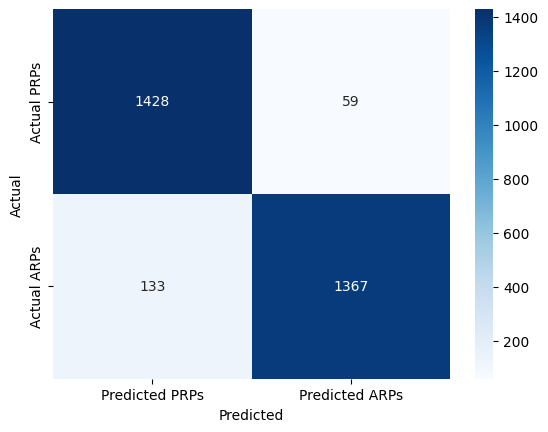

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted PRPs', 'Predicted ARPs'], yticklabels=['Actual PRPs', 'Actual ARPs'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SVM_TF-IDF

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import SVC, LinearSVC
#svm_model = SVC()
#svm_model = LinearSVC()
svm_model =LinearSVC(
    penalty='l2',       # Uses L2 regularization by default
    loss='squared_hinge', # Loss function (squared hinge loss for better optimization)
    dual=True,          # Uses dual formulation when n_samples > n_features
    tol=1e-4,           # Tolerance for stopping criteria
    C=1.0,              # Regularization strength (inverse of lambda)
    multi_class='ovr',  # One-vs-Rest (OvR) for multi-class classification
    fit_intercept=True, # Includes an intercept term
    intercept_scaling=1,# Scaling factor for intercept (only when fit_intercept=True)
    class_weight=None,  # No class weighting by default
    verbose=0,          # No logging output
    random_state=None,  # No fixed randomness
    max_iter=1000       # Maximum number of iterations for convergence
)

svm_model = svm_model.fit(X_train_vect_tf_idf, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_vect_tf_idf)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.9347171074656846
Class 0 - Precision: 0.9189364461738002, Recall: 0.952925353059852, Accuracy: 0.9347171074656846, F1-score: 0.9356223175965666
Class 1 - Precision: 0.9515570934256056, Recall: 0.9166666666666666, Accuracy: 0.9347171074656846, F1-score: 0.933786078098472


## Overall Performance:SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train LinearSVC model
#svm_model = LinearSVC()
svm_model =LinearSVC(
    penalty='l2',       # Uses L2 regularization by default
    loss='squared_hinge', # Loss function (squared hinge loss for better optimization)
    dual=True,          # Uses dual formulation when n_samples > n_features
    tol=1e-4,           # Tolerance for stopping criteria
    C=1.0,              # Regularization strength (inverse of lambda)
    multi_class='ovr',  # One-vs-Rest (OvR) for multi-class classification
    fit_intercept=True, # Includes an intercept term
    intercept_scaling=1,# Scaling factor for intercept (only when fit_intercept=True)
    class_weight=None,  # No class weighting by default
    verbose=0,          # No logging output
    random_state=None,  # No fixed randomness
    max_iter=1000       # Maximum number of iterations for convergence
)
svm_model = svm_model.fit(X_train_vect_tf_idf, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_vect_tf_idf)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')

Overall Precision: 0.9515570934256056
Overall Recall: 0.9166666666666666
Overall F1-score: 0.933786078098472
Overall Accuracy: 0.9347171074656846


## Matrix_SVM

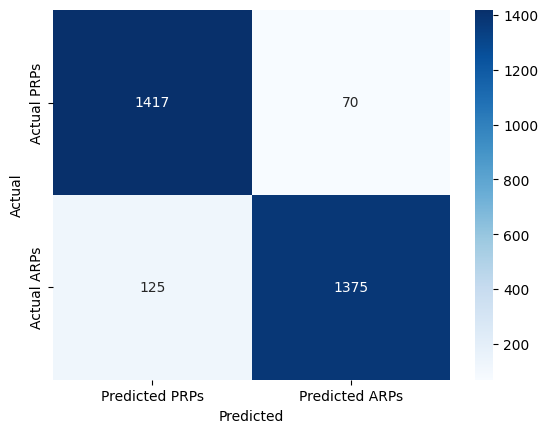

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted PRPs', 'Predicted ARPs'], yticklabels=['Actual PRPs', 'Actual ARPs'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# GridSearchCV

https://chatgpt.com/share/2d177bbf-aa11-4e78-a40b-04e4504d2933 this is a link with a working example

https://chatgpt.com/share/4200614f-4ded-4cff-8d85-f3d721492adb : this is a link for me to learn about GridSearchCV

## kNN with GriSeach and Corss-validation techiniques

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Define the parameter grid to search over
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 10],  # Possible values for n_neighbors
    'weights': ['uniform', 'distance'],  # Weights to assign to neighbors
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Search for different algorithms
}

# Initialize KNN model
knn_model = KNeighborsClassifier()

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model to the training data with cross-validation
grid_search.fit(X_train_vect_tf_idf, y_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters found by GridSearchCV: {best_params}")

# Best model
best_knn_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_knn_model.predict(X_test_vect_tf_idf)

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print out the results
print(f'Overall Accuracy: {overall_accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')
